In [1]:
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True)

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score

Reading the dataset

In [4]:
original_data = pd.read_csv('Churn_Modelling.csv')

In [5]:
data = original_data.copy()
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Removing useless columns

In [6]:
data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


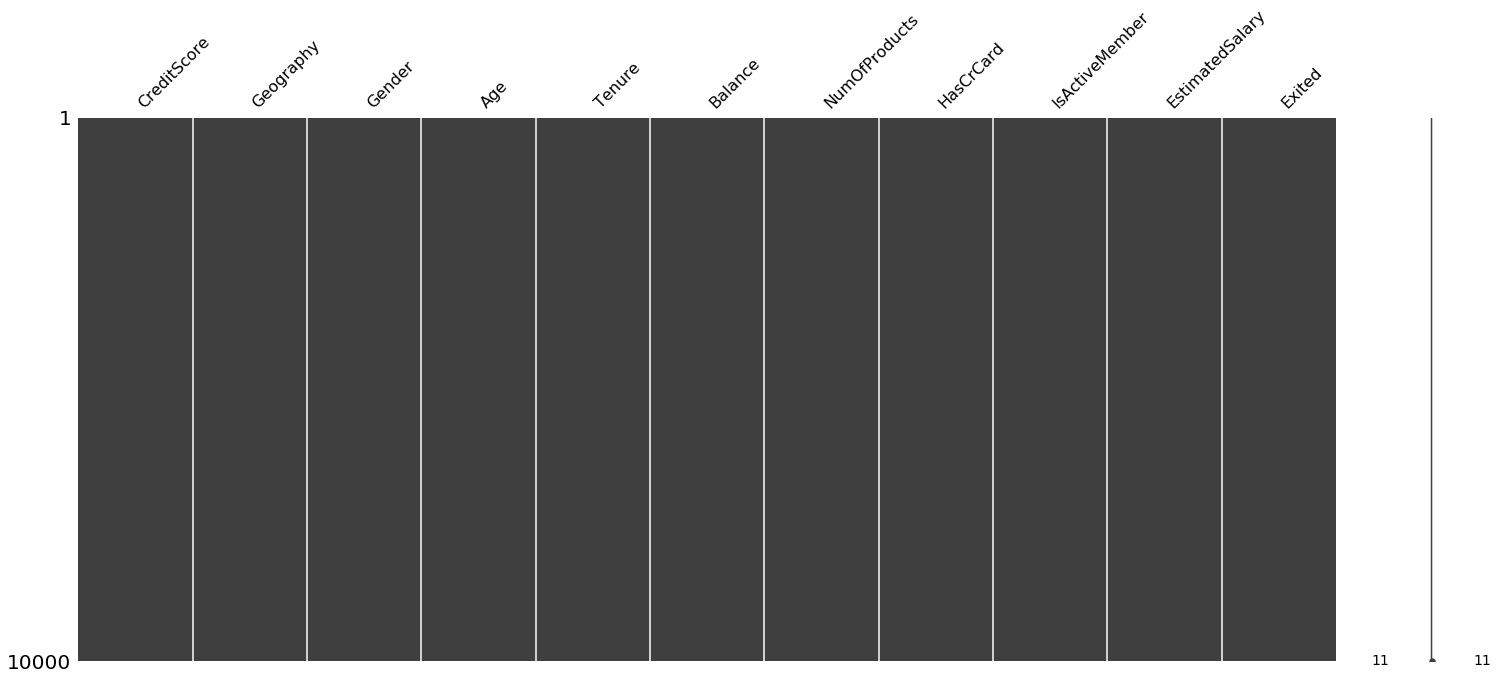

In [7]:
import missingno
missingno.matrix(data)

There are no missing values, but looks like there are some categorical columns

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


One-Hot Encoding of Categorical Columns

In [9]:
categorical_columns = data.columns[data.dtypes=='O']
categorical_columns

Index(['Geography', 'Gender'], dtype='object')

In [10]:
dummy_variables = pd.DataFrame()  # empty dataframe

for categorical_column in categorical_columns:
    dummies = pd.get_dummies(data[categorical_column])  #, drop_first=True)
    dummy_variables = pd.concat([dummy_variables, dummies], axis=1)
    
data.drop(categorical_columns, axis=1, inplace=True)
data = pd.concat([dummy_variables, data], axis=1)

data.head()

,France,Germany,Spain,Female,Male,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,0,0,1,0,619,42,2,0.00,1,1,1,101348.88,1
1,0,0,1,1,0,608,41,1,83807.86,1,0,1,112542.58,0
2,1,0,0,1,0,502,42,8,159660.80,3,1,0,113931.57,1
3,1,0,0,1,0,699,39,1,0.00,2,0,0,93826.63,0
4,0,0,1,1,0,850,43,2,125510.82,1,1,1,79084.10,0


Splitting the dataset into Independent and Dependent Variables

In [11]:
X = data.copy()
y = X.pop('Exited')

Random Forest Model

In [12]:
def build_and_evaluate_random_forest_model(X, y, scaling=False, random_state=1234):
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, random_state=random_state)
    
    # Feature Scaling (optional)
    if scaling==True:
        scaler = StandardScaler()
        xtrain = scaler.fit_transform(xtrain)
        xtest = scaler.transform(xtest)
    
    # Define a RandomForest Model
    classifier = RandomForestClassifier(n_estimators=100, random_state=random_state)
    
    # Model Training
    classifier.fit(xtrain, ytrain)
    
    # Model Evaluation
    ypred = classifier.predict(xtest)
    cm = confusion_matrix(ytest, ypred)
    accuracy = round(accuracy_score(ytest, ypred) *100, 2)
    recall = round(recall_score(ytest, ypred) * 100, 2)
    
    # Plot of Confusion Matrix
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Real')
    plt.title('Confusion Matrix')
    plt.show()
    print('\nAccuracy: {}%\nRecall: {}%\n'.format(accuracy, recall))
    
    # Plot the feature Importances
    feature_importances = pd.DataFrame({'Features': X.columns, 'Importance': classifier.feature_importances_})
    feature_importances.sort_values(by='Importance', inplace=True, ascending=False)
    sns.barplot(y=feature_importances.Features, 
                x=feature_importances.Importance, 
                data=feature_importances, 
                edgecolor=[0,0,0,1], 
                palette='Pastel2', 
                saturation=1)
    plt.show()

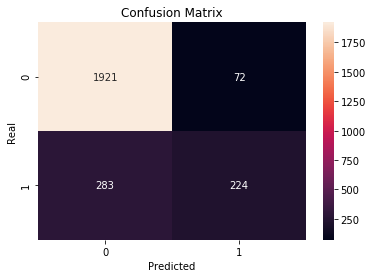


Accuracy: 85.8%
Recall: 44.18%



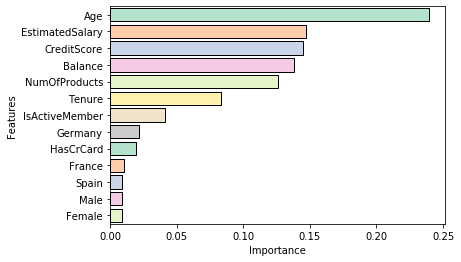

In [13]:
build_and_evaluate_random_forest_model(X,y)

Looks like Gender Column has no impact on the model. Lets remove that column abd try the model again

In [14]:
X.drop(['Male', 'Female'], axis=1, inplace=True)
X.head()

,France,Germany,Spain,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,1,0,0,619,42,2,0.00,1,1,1,101348.88
1,0,0,1,608,41,1,83807.86,1,0,1,112542.58
2,1,0,0,502,42,8,159660.80,3,1,0,113931.57
3,1,0,0,699,39,1,0.00,2,0,0,93826.63
4,0,0,1,850,43,2,125510.82,1,1,1,79084.10


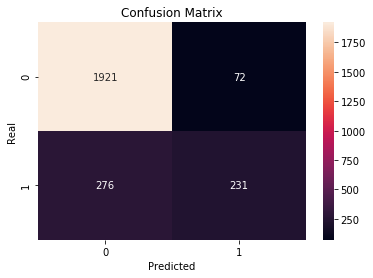


Accuracy: 86.08%
Recall: 45.56%



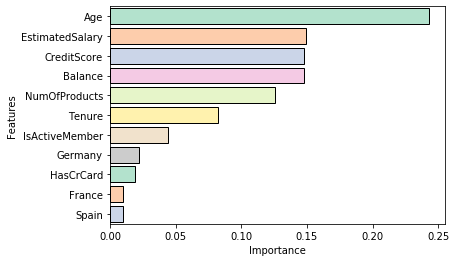

In [15]:
build_and_evaluate_random_forest_model(X,y)

Lets remove Spain and France too

In [16]:
X.drop(['Spain', 'France'], axis=1, inplace=True)
X.head()

,Germany,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,0,619,42,2,0.00,1,1,1,101348.88
1,0,608,41,1,83807.86,1,0,1,112542.58
2,0,502,42,8,159660.80,3,1,0,113931.57
3,0,699,39,1,0.00,2,0,0,93826.63
4,0,850,43,2,125510.82,1,1,1,79084.10


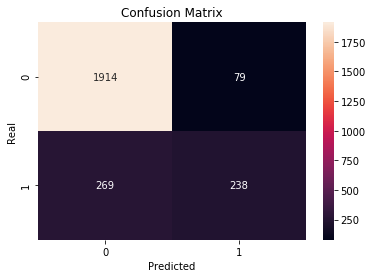


Accuracy: 86.08%
Recall: 46.94%



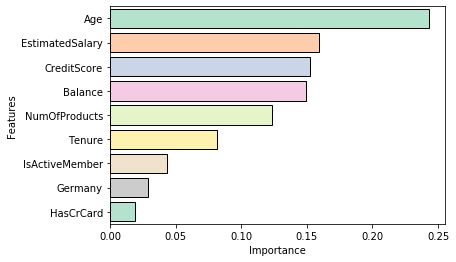

In [17]:
build_and_evaluate_random_forest_model(X,y)

Credit Score Column - Continuous to Categorical

In [18]:
X['CreditScore'].describe()

count    10000.000000
mean       650.528800
std         96.653299
min        350.000000
25%        584.000000
50%        652.000000
75%        718.000000
max        850.000000
Name: CreditScore, dtype: float64

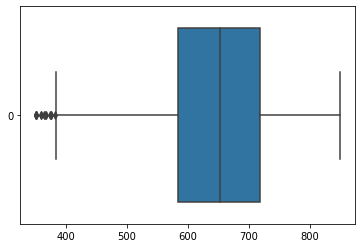

In [19]:
sns.boxplot(data=X['CreditScore'], orient='h')

![](https://www.mybanktracker.com/news/wp-content/uploads/2014/04/good-credit-score-700-750.jpg)

In [20]:
def credit_rank(num):
    # Very Bad
    if num < 560:
        return 0
    # Bad
    if num < 650:
        return 1
    # Fair
    if num < 700:
        return 2
    # Good
    if num < 750:
        return 3
    # Excellent
    else:
        return 4

In [21]:
X['CreditRank'] = X['CreditScore'].apply(credit_rank)
X.head(10)

,Germany,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,CreditRank
0,0,619,42,2,0.00,1,1,1,101348.88,1
1,0,608,41,1,83807.86,1,0,1,112542.58,1
2,0,502,42,8,159660.80,3,1,0,113931.57,0
3,0,699,39,1,0.00,2,0,0,93826.63,2
4,0,850,43,2,125510.82,1,1,1,79084.10,4
5,0,645,44,8,113755.78,2,1,0,149756.71,1
6,0,822,50,7,0.00,2,1,1,10062.80,4
7,1,376,29,4,115046.74,4,1,0,119346.88,0
8,0,501,44,4,142051.07,2,0,1,74940.50,0
9,0,684,27,2,134603.88,1,1,1,71725.73,2


In [22]:
X = X.drop('CreditScore', axis=1)
X.head()

,Germany,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,CreditRank
0,0,42,2,0.00,1,1,1,101348.88,1
1,0,41,1,83807.86,1,0,1,112542.58,1
2,0,42,8,159660.80,3,1,0,113931.57,0
3,0,39,1,0.00,2,0,0,93826.63,2
4,0,43,2,125510.82,1,1,1,79084.10,4


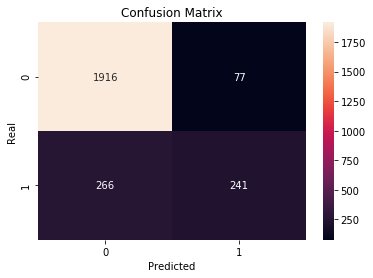


Accuracy: 86.28%
Recall: 47.53%



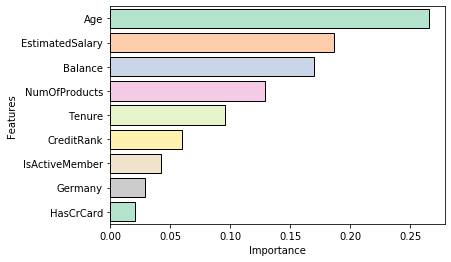

In [23]:
build_and_evaluate_random_forest_model(X,y)

Lets try Feature Scaling

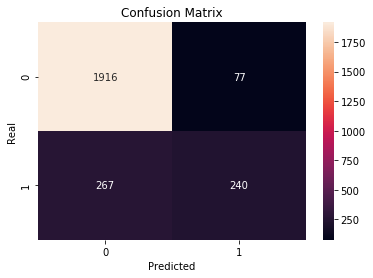


Accuracy: 86.24%
Recall: 47.34%



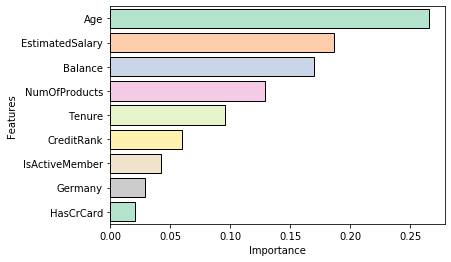

In [24]:
build_and_evaluate_random_forest_model(X,y, scaling=True)

### Artificial Neural Network

In [33]:
X.head()

,Germany,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,CreditRank
0,0,42,2,0.00,1,1,1,101348.88,1
1,0,41,1,83807.86,1,0,1,112542.58,1
2,0,42,8,159660.80,3,1,0,113931.57,0
3,0,39,1,0.00,2,0,0,93826.63,2
4,0,43,2,125510.82,1,1,1,79084.10,4


In [45]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

In [46]:
def plot_model_training_info(model_info, epochs):
    plt.figure(figsize=(16,5))
    
    plt.subplot(1,2,1)
    plt.plot(range(1, epochs+1), model_info.history['accuracy'], c='b', label='Training')
    plt.plot(range(1, epochs+1), model_info.history['val_accuracy'], c='r', label='Validation')
    plt.title("Model Accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(range(1, epochs+1), model_info.history['loss'], c='b', label='Training')
    plt.plot(range(1, epochs+1), model_info.history['val_loss'], c='r', label='Validation')
    plt.title("Model Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.suptitle("Model Training Information on Churn Dataset")
    plt.show()

In [69]:
def build_ann_model(X, y, scaling=False, epochs=15, batch_size=32):
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, random_state=1234)
    # Feature Scaling (optional)
    if scaling==True:
        scaler = StandardScaler()
        xtrain = scaler.fit_transform(xtrain)
        xtest = scaler.transform(xtest)
    # Defining the model
    model = Sequential()
    # Adding layers
    model.add(Dense(10, kernel_regularizer=l2(0.001), input_dim=len(X.columns)))
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    model.add(Dense(5, kernel_regularizer=l2(0.001)))  # activation='relu'))
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    model.add(Dense(3, kernel_regularizer=l2(0.001)))  # activation='relu'))
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))
    # Model Compilation
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    # Fitting the model
    model_info = model.fit(xtrain, ytrain, validation_split=0.2, epochs=epochs, batch_size=batch_size, verbose=1)
    # Plot model history
    plot_model_training_info(model_info, epochs)
    # Evaluation on Test Dataset
    ypred = model.predict(xtest)
    ypred = [1 if ans>=0.5 else 0 for ans in ypred]
    accuracy = round(accuracy_score(ytest, ypred) *100, 2)
    recall = round(recall_score(ytest, ypred) * 100, 2)
    print('\nPerformance on Test Data:\nAccuracy: {}%\nRecall: {}%\n'.format(accuracy, recall))
    # Plot of Confusion Matrix
    cm = confusion_matrix(ytest, ypred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Real')
    plt.title('Confusion Matrix')
    plt.show()

Train on 6000 samples, validate on 1500 samples
Epoch 1/500
6000/6000 [==============================] - 0s 77us/step - loss: 0.6481 - accuracy: 0.7565 - val_loss: 0.6156 - val_accuracy: 0.7953
Epoch 2/500
6000/6000 [==============================] - 0s 15us/step - loss: 0.6024 - accuracy: 0.7802 - val_loss: 0.5725 - val_accuracy: 0.7960
Epoch 3/500
6000/6000 [==============================] - 0s 14us/step - loss: 0.5727 - accuracy: 0.7833 - val_loss: 0.5394 - val_accuracy: 0.7960
Epoch 4/500
6000/6000 [==============================] - 0s 14us/step - loss: 0.5551 - accuracy: 0.7942 - val_loss: 0.5167 - val_accuracy: 0.7960
Epoch 5/500
6000/6000 [==============================] - 0s 15us/step - loss: 0.5344 - accuracy: 0.7953 - val_loss: 0.5003 - val_accuracy: 0.7960
Epoch 6/500
6000/6000 [==============================] - 0s 16us/step - loss: 0.5153 - accuracy: 0.7925 - val_loss: 0.4882 - val_accuracy: 0.7960
Epoch 7/500
6000/6000 [==============================] - 0s 17us/step - loss

6000/6000 [==============================] - 0s 20us/step - loss: 0.4218 - accuracy: 0.7960 - val_loss: 0.3910 - val_accuracy: 0.7960
Epoch 57/500
6000/6000 [==============================] - 0s 18us/step - loss: 0.4184 - accuracy: 0.7960 - val_loss: 0.3901 - val_accuracy: 0.7960
Epoch 58/500
6000/6000 [==============================] - 0s 17us/step - loss: 0.4155 - accuracy: 0.7960 - val_loss: 0.3892 - val_accuracy: 0.7960
Epoch 59/500
6000/6000 [==============================] - 0s 13us/step - loss: 0.4136 - accuracy: 0.7960 - val_loss: 0.3887 - val_accuracy: 0.7960
Epoch 60/500
6000/6000 [==============================] - 0s 15us/step - loss: 0.4154 - accuracy: 0.7960 - val_loss: 0.3878 - val_accuracy: 0.7960
Epoch 61/500
6000/6000 [==============================] - 0s 17us/step - loss: 0.4142 - accuracy: 0.7960 - val_loss: 0.3870 - val_accuracy: 0.7960
Epoch 62/500
6000/6000 [==============================] - 0s 16us/step - loss: 0.4148 - accuracy: 0.7960 - val_loss: 0.3866 - val_a

6000/6000 [==============================] - 0s 15us/step - loss: 0.4020 - accuracy: 0.8428 - val_loss: 0.3724 - val_accuracy: 0.8560
Epoch 112/500
6000/6000 [==============================] - 0s 14us/step - loss: 0.4023 - accuracy: 0.8433 - val_loss: 0.3721 - val_accuracy: 0.8573
Epoch 113/500
6000/6000 [==============================] - 0s 13us/step - loss: 0.3977 - accuracy: 0.8428 - val_loss: 0.3718 - val_accuracy: 0.8593
Epoch 114/500
6000/6000 [==============================] - 0s 14us/step - loss: 0.4031 - accuracy: 0.8417 - val_loss: 0.3721 - val_accuracy: 0.8553
Epoch 115/500
6000/6000 [==============================] - 0s 13us/step - loss: 0.3960 - accuracy: 0.8455 - val_loss: 0.3714 - val_accuracy: 0.8573
Epoch 116/500
6000/6000 [==============================] - 0s 14us/step - loss: 0.3970 - accuracy: 0.8417 - val_loss: 0.3710 - val_accuracy: 0.8567
Epoch 117/500
6000/6000 [==============================] - 0s 14us/step - loss: 0.3981 - accuracy: 0.8423 - val_loss: 0.3710 -

6000/6000 [==============================] - 0s 17us/step - loss: 0.3952 - accuracy: 0.8443 - val_loss: 0.3664 - val_accuracy: 0.8647
Epoch 167/500
6000/6000 [==============================] - 0s 14us/step - loss: 0.3970 - accuracy: 0.8462 - val_loss: 0.3662 - val_accuracy: 0.8627
Epoch 168/500
6000/6000 [==============================] - 0s 14us/step - loss: 0.3969 - accuracy: 0.8438 - val_loss: 0.3668 - val_accuracy: 0.8627
Epoch 169/500
6000/6000 [==============================] - 0s 13us/step - loss: 0.3971 - accuracy: 0.8410 - val_loss: 0.3657 - val_accuracy: 0.8640
Epoch 170/500
6000/6000 [==============================] - 0s 14us/step - loss: 0.3954 - accuracy: 0.8455 - val_loss: 0.3656 - val_accuracy: 0.8627
Epoch 171/500
6000/6000 [==============================] - 0s 14us/step - loss: 0.3928 - accuracy: 0.8425 - val_loss: 0.3655 - val_accuracy: 0.8627
Epoch 172/500
6000/6000 [==============================] - 0s 14us/step - loss: 0.3962 - accuracy: 0.8457 - val_loss: 0.3655 -

6000/6000 [==============================] - 0s 16us/step - loss: 0.3942 - accuracy: 0.8478 - val_loss: 0.3615 - val_accuracy: 0.8653
Epoch 222/500
6000/6000 [==============================] - 0s 13us/step - loss: 0.3936 - accuracy: 0.8445 - val_loss: 0.3609 - val_accuracy: 0.8687
Epoch 223/500
6000/6000 [==============================] - 0s 14us/step - loss: 0.3913 - accuracy: 0.8430 - val_loss: 0.3614 - val_accuracy: 0.8667
Epoch 224/500
6000/6000 [==============================] - 0s 15us/step - loss: 0.4013 - accuracy: 0.8432 - val_loss: 0.3619 - val_accuracy: 0.8627
Epoch 225/500
6000/6000 [==============================] - 0s 14us/step - loss: 0.3952 - accuracy: 0.8462 - val_loss: 0.3620 - val_accuracy: 0.8640
Epoch 226/500
6000/6000 [==============================] - 0s 14us/step - loss: 0.3901 - accuracy: 0.8480 - val_loss: 0.3610 - val_accuracy: 0.8660
Epoch 227/500
6000/6000 [==============================] - 0s 14us/step - loss: 0.3969 - accuracy: 0.8453 - val_loss: 0.3616 -

6000/6000 [==============================] - 0s 15us/step - loss: 0.3936 - accuracy: 0.8427 - val_loss: 0.3592 - val_accuracy: 0.8693
Epoch 277/500
6000/6000 [==============================] - 0s 17us/step - loss: 0.3937 - accuracy: 0.8440 - val_loss: 0.3591 - val_accuracy: 0.8680
Epoch 278/500
6000/6000 [==============================] - 0s 17us/step - loss: 0.3980 - accuracy: 0.8408 - val_loss: 0.3598 - val_accuracy: 0.8667
Epoch 279/500
6000/6000 [==============================] - 0s 15us/step - loss: 0.3924 - accuracy: 0.8455 - val_loss: 0.3599 - val_accuracy: 0.8660
Epoch 280/500
6000/6000 [==============================] - 0s 15us/step - loss: 0.3921 - accuracy: 0.8420 - val_loss: 0.3596 - val_accuracy: 0.8667
Epoch 281/500
6000/6000 [==============================] - 0s 15us/step - loss: 0.3978 - accuracy: 0.8445 - val_loss: 0.3599 - val_accuracy: 0.8647
Epoch 282/500
6000/6000 [==============================] - 0s 15us/step - loss: 0.3924 - accuracy: 0.8440 - val_loss: 0.3597 -

6000/6000 [==============================] - 0s 15us/step - loss: 0.3938 - accuracy: 0.8443 - val_loss: 0.3585 - val_accuracy: 0.8680
Epoch 332/500
6000/6000 [==============================] - 0s 15us/step - loss: 0.3943 - accuracy: 0.8415 - val_loss: 0.3585 - val_accuracy: 0.8713
Epoch 333/500
6000/6000 [==============================] - 0s 14us/step - loss: 0.3876 - accuracy: 0.8510 - val_loss: 0.3581 - val_accuracy: 0.8693
Epoch 334/500
6000/6000 [==============================] - 0s 14us/step - loss: 0.3935 - accuracy: 0.8447 - val_loss: 0.3575 - val_accuracy: 0.8700
Epoch 335/500
6000/6000 [==============================] - 0s 14us/step - loss: 0.3879 - accuracy: 0.8487 - val_loss: 0.3578 - val_accuracy: 0.8680
Epoch 336/500
6000/6000 [==============================] - 0s 14us/step - loss: 0.3877 - accuracy: 0.8472 - val_loss: 0.3575 - val_accuracy: 0.8680
Epoch 337/500
6000/6000 [==============================] - 0s 14us/step - loss: 0.3926 - accuracy: 0.8457 - val_loss: 0.3580 -

6000/6000 [==============================] - 0s 16us/step - loss: 0.3902 - accuracy: 0.8465 - val_loss: 0.3574 - val_accuracy: 0.8693
Epoch 387/500
6000/6000 [==============================] - 0s 14us/step - loss: 0.3861 - accuracy: 0.8512 - val_loss: 0.3572 - val_accuracy: 0.8673
Epoch 388/500
6000/6000 [==============================] - 0s 14us/step - loss: 0.3878 - accuracy: 0.8460 - val_loss: 0.3569 - val_accuracy: 0.8693
Epoch 389/500
6000/6000 [==============================] - 0s 14us/step - loss: 0.3928 - accuracy: 0.8470 - val_loss: 0.3569 - val_accuracy: 0.8693
Epoch 390/500
6000/6000 [==============================] - 0s 13us/step - loss: 0.3927 - accuracy: 0.8467 - val_loss: 0.3572 - val_accuracy: 0.8700
Epoch 391/500
6000/6000 [==============================] - 0s 13us/step - loss: 0.3872 - accuracy: 0.8462 - val_loss: 0.3566 - val_accuracy: 0.8673
Epoch 392/500
6000/6000 [==============================] - 0s 14us/step - loss: 0.3881 - accuracy: 0.8473 - val_loss: 0.3564 -

6000/6000 [==============================] - 0s 15us/step - loss: 0.3892 - accuracy: 0.8463 - val_loss: 0.3581 - val_accuracy: 0.8700
Epoch 442/500
6000/6000 [==============================] - 0s 15us/step - loss: 0.3952 - accuracy: 0.8447 - val_loss: 0.3573 - val_accuracy: 0.8713
Epoch 443/500
6000/6000 [==============================] - 0s 15us/step - loss: 0.3936 - accuracy: 0.8458 - val_loss: 0.3571 - val_accuracy: 0.8693
Epoch 444/500
6000/6000 [==============================] - 0s 15us/step - loss: 0.3934 - accuracy: 0.8402 - val_loss: 0.3581 - val_accuracy: 0.8687
Epoch 445/500
6000/6000 [==============================] - 0s 15us/step - loss: 0.3927 - accuracy: 0.8455 - val_loss: 0.3577 - val_accuracy: 0.8727
Epoch 446/500
6000/6000 [==============================] - 0s 14us/step - loss: 0.3951 - accuracy: 0.8425 - val_loss: 0.3572 - val_accuracy: 0.8720
Epoch 447/500
6000/6000 [==============================] - 0s 15us/step - loss: 0.3888 - accuracy: 0.8453 - val_loss: 0.3571 -

6000/6000 [==============================] - 0s 15us/step - loss: 0.3891 - accuracy: 0.8428 - val_loss: 0.3565 - val_accuracy: 0.8713
Epoch 497/500
6000/6000 [==============================] - 0s 13us/step - loss: 0.3910 - accuracy: 0.8457 - val_loss: 0.3574 - val_accuracy: 0.8713
Epoch 498/500
6000/6000 [==============================] - 0s 14us/step - loss: 0.3887 - accuracy: 0.8495 - val_loss: 0.3572 - val_accuracy: 0.8687
Epoch 499/500
6000/6000 [==============================] - 0s 14us/step - loss: 0.3880 - accuracy: 0.8483 - val_loss: 0.3561 - val_accuracy: 0.8720
Epoch 500/500
6000/6000 [==============================] - 0s 13us/step - loss: 0.3875 - accuracy: 0.8432 - val_loss: 0.3557 - val_accuracy: 0.8693


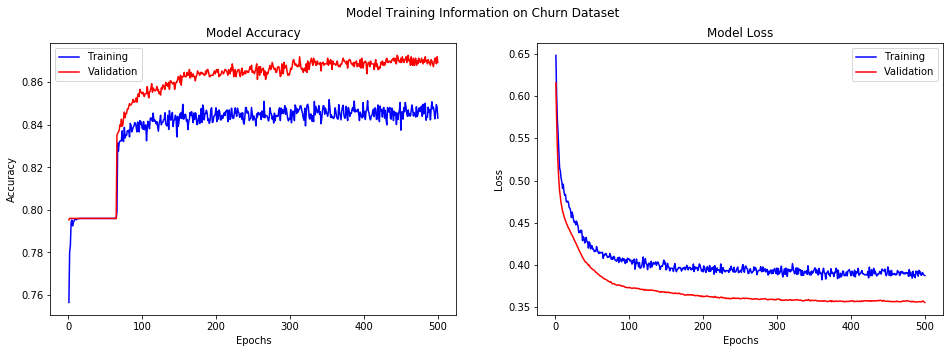


Performance on Test Data:
Accuracy: 85.6%
Recall: 43.59%



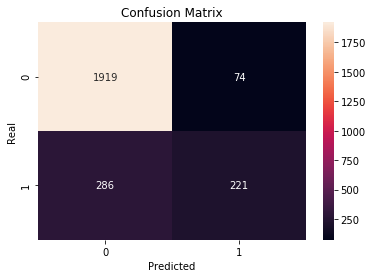

In [70]:
build_ann_model(X, y, scaling=True, epochs=500, batch_size=200)